# Approximating data using deep learning

Note that for this approach we based ourselves on the Standford lecture notes on convolutional neural networks for visual recognition.

This lecture is open source and can be found on http://cs231n.github.io/ 

In [44]:
# Clean up the memory
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import gc

import numpy as np
import math

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = "data/"
SESSION_FOLDER = "session/"

TRAIN_SET_PERC = 0.9

In [3]:
def save_session(filename, nb_iterations = -1):
    '''
    Saves a seesion in a file with the given filename
    A number of iterations can also be given 
    :param : String
    :param : int
    '''
    saver = tf.train.Saver()
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    if nb_iterations >= 0:
        saver.save(sess, SESSION_FOLDER + filename, global_step=nb_iterations)
    else:
        saver.save(sess, SESSION_FOLDER + filename)
        
    print("Session saved with filename {}.".format(filename))
    
def restore_session(filename):
    '''
    Restores a tensorflow session stored in the given filename
    After the call of this function, the sessios's variable will be available again
    :param : String
    '''
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph(SESSION_FOLDER + filename + '.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))
        
def garbage_collection():
    '''
    Calls garbage collection to clean unused memory
    '''
    gc.collect()

In [13]:
def rmse(pred, real, loop = True):
    '''
    Computes RMSE between predictions and real values
    :param : float[]
    :param : float[]
    :return : float
    '''
    if len(pred) != len(real):
        print("RMSE Error : Predictions and real values arrays do not have the same length, aborting.")
        return None
    
    if loop:
        mse = 0
        for i in range(len(pred)):
            mse += (pred[i] - real[i])**2
        return math.sqrt(mse/len(pred))
    else:
        # The creation of the array may produce memory error
        err = pred - real
        mse = err.T @ err
        return math.sqrt(2 * mse / len(pred))

In [5]:
def plot_history(history):
    '''
    Plots the history of the training error
    Usefull 
    '''
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

## Preparing the data



In [6]:
# Use non normalized feature matrix
# For now best results are given with this one
#X = np.load(DATA_FOLDER + "feature_mat_radial_compression.npy")

# Use normalized feature matrix
################################################################################################
# Careful                                                                                      #
# Normally, normalisation should be done one each train/val/test matrices. It is not done here #
################################################################################################
X = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [11]:
# Prepare train and test set

train_set_size = int(len(X) * TRAIN_SET_PERC)
X_train = X[: train_set_size]
X_test = X[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [12]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30049, 15961)
y: (30049,)


# Single neural network model approach

First we will do a single model approach, the goal is to see quickly how we can build a model using neural networks and how well it does. 

In [14]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [15]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 200
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.1
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 33s 1ms/step - loss: 16.2263 - mean_absolute_error: 2.3938 - val_loss: 6.2262 - val_mean_absolute_error: 1.8358
Epoch 2/200
24339/24339 [==============================] - 33s 1ms/step - loss: 3.2662 - mean_absolute_error: 1.3039 - val_loss: 4.0006 - val_mean_absolute_error: 1.4015
Epoch 3/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.8035 - mean_absolute_error: 0.9428 - val_loss: 4.2133 - val_mean_absolute_error: 1.4561
Epoch 4/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.7472 - mean_absolute_error: 0.9308 - val_loss: 3.5445 - val_mean_absolute_error: 1.3147
Epoch 5/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.4083 - mean_absolute_error: 0.8200 - val_loss: 3.1718 - val_mean_absolute_error: 1.2550
Epoch 6/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.9822 - mean_absolu

Epoch 49/200
24339/24339 [==============================] - 33s 1ms/step - loss: 0.2332 - mean_absolute_error: 0.2662 - val_loss: 0.6181 - val_mean_absolute_error: 0.5156
Epoch 50/200
24339/24339 [==============================] - 32s 1ms/step - loss: 0.2462 - mean_absolute_error: 0.2666 - val_loss: 0.5834 - val_mean_absolute_error: 0.4958
Epoch 51/200
24339/24339 [==============================] - 34s 1ms/step - loss: 0.2626 - mean_absolute_error: 0.2700 - val_loss: 0.6383 - val_mean_absolute_error: 0.5298
Epoch 52/200
24339/24339 [==============================] - 35s 1ms/step - loss: 0.2387 - mean_absolute_error: 0.2609 - val_loss: 0.6260 - val_mean_absolute_error: 0.5193
Epoch 53/200
24339/24339 [==============================] - 33s 1ms/step - loss: 0.2534 - mean_absolute_error: 0.2679 - val_loss: 0.7373 - val_mean_absolute_error: 0.5672
Epoch 54/200
24339/24339 [==============================] - 30s 1ms/step - loss: 0.2392 - mean_absolute_error: 0.2541 - val_loss: 0.6180 - val_me

Epoch 97/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1789 - mean_absolute_error: 0.2405 - val_loss: 0.6396 - val_mean_absolute_error: 0.5494
Epoch 98/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1754 - mean_absolute_error: 0.2384 - val_loss: 0.5826 - val_mean_absolute_error: 0.5109
Epoch 99/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1846 - mean_absolute_error: 0.2464 - val_loss: 0.6068 - val_mean_absolute_error: 0.5251
Epoch 100/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1732 - mean_absolute_error: 0.2346 - val_loss: 0.5752 - val_mean_absolute_error: 0.4983
Epoch 101/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1945 - mean_absolute_error: 0.2554 - val_loss: 0.5877 - val_mean_absolute_error: 0.5083
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dens

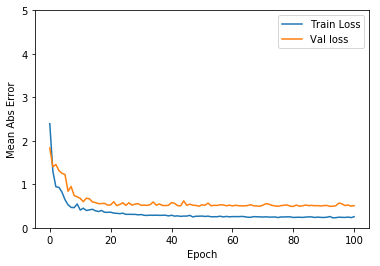

In [16]:
plot_history(history)

In [17]:
result = model.predict(X_test, batch_size=32)
rmse(result, y_test)

0.6604633181447641

## Results

For the following model :
    - 4 hidden layers of 64 neurons - relu activation.
    - A result layer of 1 neuron - relu activation.
    - Early stopping callback
    - Test split of 0.2
    - Using AdamOptimizer gives best results.
    - No cross validation.
    
Network size :
- $4*64 + 1 = 257$ neurons (biases)
- $30049*64 + 64*64 + 64*64 + 64 = 1931392$ weights
- Total of $1931649$ learnable parameters (almost 2 millions)

With the above, we reached a RMSE of 0.5. But this is without separating the data into train and test set. This can lead to overfitting. Now we need to ensure that we are not overfitting.

For this we will test 2 solutions :

### Change our implementation to add regulizer that will avoid this overfitting

### Cross validation over multiple models

# Multi neural network approach

In [11]:
def create_k_models(X, y, k):
    split = len(X) // k
    
    # Create subsets of X
    X_subsets = []
    y_subsets = []
    for i in range(k - 1):
        X_subsets.append(X[i*split : (i + 1)*split])
        y_subsets.append(y[i*split : (i + 1)*split])
    X_subsets.append(X[(k-1)*split :])
    y_subsets.append(y[(k - 1)*split :])
    
    # Create models
    models = []
    for i in range(k):
        model = tf.keras.Sequential([
        # Assuming each layer represent a link between particules, we begin with 4 layers
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        # Last layer represent the electromagnetic shielding, our prediction
        layers.Dense(1, activation='relu')])

        model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='mse',
                  # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
                  metrics=['mae'])
        
        EPOCHS = 200
        BATCH_SIZE = 32
        VALIDATION_SPLIT = 0.2
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        
        flatten = lambda l: np.array([item for sublist in l for item in sublist])
        X_model = flatten(X_subsets[0 : i] + X_subsets[(i + 1) :])
        y_model = flatten(y_subsets[0 : i] + y_subsets[(i + 1) :])
        print(X_model.shape, y_model.shape)
        model.fit(X_model, y_model, \
                  epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
                  callbacks=[early_stop])
        models.append(model)
        
    return models

In [12]:
def k_predictions(X_test, models):
    predictions = []
    for model in models:
        predictions.append(model.predict(X_test, batch_size=32))
    return np.mean(predictions, axis = 0)

In [13]:
# For now training on 2000 features, memory errors otherwise. Change when feature selection on point
models = create_k_models(X_train[:, : 2000], y_train, 4)

(20283, 2000) (20283,)
Train on 16226 samples, validate on 4057 samples
Epoch 1/200
16226/16226 [==============================] - 3s 168us/step - loss: 30.0769 - mean_absolute_error: 3.0378 - val_loss: 6.0630 - val_mean_absolute_error: 1.8248
Epoch 2/200
16226/16226 [==============================] - 1s 80us/step - loss: 2.3231 - mean_absolute_error: 1.1593 - val_loss: 4.8266 - val_mean_absolute_error: 1.6400
Epoch 3/200
16226/16226 [==============================] - 1s 82us/step - loss: 1.6784 - mean_absolute_error: 0.9793 - val_loss: 4.4746 - val_mean_absolute_error: 1.5627
Epoch 4/200
16226/16226 [==============================] - 1s 75us/step - loss: 1.4042 - mean_absolute_error: 0.9045 - val_loss: 4.4405 - val_mean_absolute_error: 1.5434
Epoch 5/200
16226/16226 [==============================] - 1s 68us/step - loss: 1.3661 - mean_absolute_error: 0.8996 - val_loss: 4.7473 - val_mean_absolute_error: 1.6319
Epoch 6/200
16226/16226 [==============================] - 1s 64us/step - lo

16226/16226 [==============================] - 1s 64us/step - loss: 0.2303 - mean_absolute_error: 0.3658 - val_loss: 2.1982 - val_mean_absolute_error: 1.0572
Epoch 49/200
16226/16226 [==============================] - 1s 63us/step - loss: 0.2609 - mean_absolute_error: 0.3846 - val_loss: 2.0411 - val_mean_absolute_error: 1.0099
Epoch 50/200
16226/16226 [==============================] - 1s 63us/step - loss: 0.2206 - mean_absolute_error: 0.3556 - val_loss: 2.0147 - val_mean_absolute_error: 1.0038
Epoch 51/200
16226/16226 [==============================] - 1s 63us/step - loss: 0.2194 - mean_absolute_error: 0.3570 - val_loss: 1.9604 - val_mean_absolute_error: 1.0091
Epoch 52/200
16226/16226 [==============================] - 1s 65us/step - loss: 0.2239 - mean_absolute_error: 0.3569 - val_loss: 2.1639 - val_mean_absolute_error: 1.0726
Epoch 53/200
16226/16226 [==============================] - 1s 63us/step - loss: 0.2114 - mean_absolute_error: 0.3502 - val_loss: 2.2018 - val_mean_absolute_e

Epoch 96/200
16226/16226 [==============================] - 1s 69us/step - loss: 0.1073 - mean_absolute_error: 0.2435 - val_loss: 1.6788 - val_mean_absolute_error: 0.9028
Epoch 97/200
16226/16226 [==============================] - 1s 67us/step - loss: 0.1213 - mean_absolute_error: 0.2559 - val_loss: 1.5806 - val_mean_absolute_error: 0.8689
Epoch 98/200
16226/16226 [==============================] - 1s 69us/step - loss: 0.1088 - mean_absolute_error: 0.2484 - val_loss: 1.6441 - val_mean_absolute_error: 0.9162
Epoch 99/200
16226/16226 [==============================] - 1s 69us/step - loss: 0.0958 - mean_absolute_error: 0.2321 - val_loss: 1.5612 - val_mean_absolute_error: 0.8652
Epoch 100/200
16226/16226 [==============================] - 1s 67us/step - loss: 0.1012 - mean_absolute_error: 0.2363 - val_loss: 1.6797 - val_mean_absolute_error: 0.9168
Epoch 101/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.1250 - mean_absolute_error: 0.2626 - val_loss: 1.5289 - val_

16226/16226 [==============================] - 1s 82us/step - loss: 0.0662 - mean_absolute_error: 0.1910 - val_loss: 1.4649 - val_mean_absolute_error: 0.8292
Epoch 144/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.0629 - mean_absolute_error: 0.1868 - val_loss: 1.4607 - val_mean_absolute_error: 0.8385
Epoch 145/200
16226/16226 [==============================] - 1s 79us/step - loss: 0.0560 - mean_absolute_error: 0.1760 - val_loss: 1.4247 - val_mean_absolute_error: 0.8212
Epoch 146/200
16226/16226 [==============================] - 1s 78us/step - loss: 0.0598 - mean_absolute_error: 0.1803 - val_loss: 1.4429 - val_mean_absolute_error: 0.8227
Epoch 147/200
16226/16226 [==============================] - 1s 79us/step - loss: 0.0714 - mean_absolute_error: 0.1980 - val_loss: 1.4001 - val_mean_absolute_error: 0.8157
Epoch 148/200
16226/16226 [==============================] - 1s 81us/step - loss: 0.0707 - mean_absolute_error: 0.1945 - val_loss: 1.4112 - val_mean_absol

Epoch 191/200
16226/16226 [==============================] - 1s 70us/step - loss: 0.0414 - mean_absolute_error: 0.1460 - val_loss: 1.3925 - val_mean_absolute_error: 0.8071
Epoch 192/200
16226/16226 [==============================] - 1s 84us/step - loss: 0.0362 - mean_absolute_error: 0.1393 - val_loss: 1.3519 - val_mean_absolute_error: 0.7878
Epoch 193/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.0414 - mean_absolute_error: 0.1490 - val_loss: 1.3455 - val_mean_absolute_error: 0.7776
Epoch 194/200
16226/16226 [==============================] - 1s 79us/step - loss: 0.0461 - mean_absolute_error: 0.1550 - val_loss: 1.3404 - val_mean_absolute_error: 0.7873
Epoch 195/200
16226/16226 [==============================] - 1s 73us/step - loss: 0.0490 - mean_absolute_error: 0.1638 - val_loss: 1.3321 - val_mean_absolute_error: 0.7794
Epoch 196/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.0506 - mean_absolute_error: 0.1632 - val_loss: 1.3255 - 

16226/16226 [==============================] - 1s 72us/step - loss: 0.2916 - mean_absolute_error: 0.4132 - val_loss: 2.3456 - val_mean_absolute_error: 1.0817
Epoch 39/200
16226/16226 [==============================] - 1s 71us/step - loss: 0.2659 - mean_absolute_error: 0.3951 - val_loss: 2.2633 - val_mean_absolute_error: 1.0307
Epoch 40/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.2967 - mean_absolute_error: 0.4098 - val_loss: 2.1889 - val_mean_absolute_error: 1.0291
Epoch 41/200
16226/16226 [==============================] - 1s 71us/step - loss: 0.2362 - mean_absolute_error: 0.3703 - val_loss: 2.4578 - val_mean_absolute_error: 1.1203
Epoch 42/200
16226/16226 [==============================] - 1s 71us/step - loss: 0.2581 - mean_absolute_error: 0.3858 - val_loss: 2.1140 - val_mean_absolute_error: 0.9974
Epoch 43/200
16226/16226 [==============================] - 1s 71us/step - loss: 0.2369 - mean_absolute_error: 0.3712 - val_loss: 2.2308 - val_mean_absolute_e

Epoch 86/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.1020 - mean_absolute_error: 0.2413 - val_loss: 1.9437 - val_mean_absolute_error: 0.9942
Epoch 87/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.1133 - mean_absolute_error: 0.2556 - val_loss: 1.6537 - val_mean_absolute_error: 0.8741
Epoch 88/200
16226/16226 [==============================] - 1s 73us/step - loss: 0.0983 - mean_absolute_error: 0.2361 - val_loss: 1.6524 - val_mean_absolute_error: 0.8946
Epoch 89/200
16226/16226 [==============================] - 1s 73us/step - loss: 0.1103 - mean_absolute_error: 0.2500 - val_loss: 1.5823 - val_mean_absolute_error: 0.8543
Epoch 90/200
16226/16226 [==============================] - 1s 86us/step - loss: 0.0986 - mean_absolute_error: 0.2356 - val_loss: 1.6008 - val_mean_absolute_error: 0.8602
Epoch 91/200
16226/16226 [==============================] - 1s 73us/step - loss: 0.1068 - mean_absolute_error: 0.2435 - val_loss: 1.6667 - val_me

Epoch 134/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.0557 - mean_absolute_error: 0.1758 - val_loss: 1.4677 - val_mean_absolute_error: 0.8330
Epoch 135/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.0571 - mean_absolute_error: 0.1782 - val_loss: 1.4606 - val_mean_absolute_error: 0.8108
Epoch 136/200
16226/16226 [==============================] - 1s 71us/step - loss: 0.0642 - mean_absolute_error: 0.1864 - val_loss: 1.4839 - val_mean_absolute_error: 0.8549
Epoch 137/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.0733 - mean_absolute_error: 0.1975 - val_loss: 1.4402 - val_mean_absolute_error: 0.8038
Epoch 138/200
16226/16226 [==============================] - 1s 71us/step - loss: 0.0672 - mean_absolute_error: 0.1958 - val_loss: 1.4582 - val_mean_absolute_error: 0.8124
Epoch 139/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.0533 - mean_absolute_error: 0.1708 - val_loss: 1.4389 - 

16226/16226 [==============================] - 1s 71us/step - loss: 0.0430 - mean_absolute_error: 0.1510 - val_loss: 1.3540 - val_mean_absolute_error: 0.7639
Epoch 182/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.0427 - mean_absolute_error: 0.1476 - val_loss: 1.4043 - val_mean_absolute_error: 0.7838
Epoch 183/200
16226/16226 [==============================] - 1s 73us/step - loss: 0.0421 - mean_absolute_error: 0.1507 - val_loss: 1.3995 - val_mean_absolute_error: 0.7845
Epoch 184/200
16226/16226 [==============================] - 1s 71us/step - loss: 0.0426 - mean_absolute_error: 0.1541 - val_loss: 1.3490 - val_mean_absolute_error: 0.7696
Epoch 185/200
16226/16226 [==============================] - 1s 72us/step - loss: 0.0392 - mean_absolute_error: 0.1459 - val_loss: 1.3590 - val_mean_absolute_error: 0.7672
Epoch 186/200
16226/16226 [==============================] - 1s 73us/step - loss: 0.0408 - mean_absolute_error: 0.1470 - val_loss: 1.4229 - val_mean_absol

16226/16226 [==============================] - 1s 75us/step - loss: 0.3915 - mean_absolute_error: 0.4766 - val_loss: 2.2416 - val_mean_absolute_error: 1.0463
Epoch 29/200
16226/16226 [==============================] - 1s 76us/step - loss: 0.4028 - mean_absolute_error: 0.4873 - val_loss: 2.3341 - val_mean_absolute_error: 1.0681
Epoch 30/200
16226/16226 [==============================] - 1s 75us/step - loss: 0.3476 - mean_absolute_error: 0.4478 - val_loss: 2.1634 - val_mean_absolute_error: 1.0212
Epoch 31/200
16226/16226 [==============================] - 1s 76us/step - loss: 0.3787 - mean_absolute_error: 0.4697 - val_loss: 2.7296 - val_mean_absolute_error: 1.1760
Epoch 32/200
16226/16226 [==============================] - 1s 75us/step - loss: 0.3677 - mean_absolute_error: 0.4619 - val_loss: 2.4846 - val_mean_absolute_error: 1.0983
Epoch 33/200
16226/16226 [==============================] - 1s 76us/step - loss: 0.3519 - mean_absolute_error: 0.4538 - val_loss: 2.3936 - val_mean_absolute_e

Epoch 76/200
16226/16226 [==============================] - 1s 78us/step - loss: 0.1369 - mean_absolute_error: 0.2708 - val_loss: 1.5509 - val_mean_absolute_error: 0.8269
Epoch 77/200
16226/16226 [==============================] - 1s 76us/step - loss: 0.1228 - mean_absolute_error: 0.2588 - val_loss: 1.5859 - val_mean_absolute_error: 0.8953
Epoch 78/200
16226/16226 [==============================] - 1s 75us/step - loss: 0.1250 - mean_absolute_error: 0.2622 - val_loss: 1.5241 - val_mean_absolute_error: 0.8202
Epoch 79/200
16226/16226 [==============================] - 1s 76us/step - loss: 0.1386 - mean_absolute_error: 0.2670 - val_loss: 1.4753 - val_mean_absolute_error: 0.8018
Epoch 80/200
16226/16226 [==============================] - 1s 75us/step - loss: 0.1068 - mean_absolute_error: 0.2437 - val_loss: 1.5626 - val_mean_absolute_error: 0.8464
Epoch 81/200
16226/16226 [==============================] - 1s 76us/step - loss: 0.1125 - mean_absolute_error: 0.2489 - val_loss: 1.4320 - val_me

Epoch 124/200
16226/16226 [==============================] - 1s 78us/step - loss: 0.0726 - mean_absolute_error: 0.1949 - val_loss: 1.3634 - val_mean_absolute_error: 0.7763
Epoch 125/200
16226/16226 [==============================] - 1s 76us/step - loss: 0.0643 - mean_absolute_error: 0.1854 - val_loss: 1.3644 - val_mean_absolute_error: 0.7555
Epoch 126/200
16226/16226 [==============================] - 1s 78us/step - loss: 0.0700 - mean_absolute_error: 0.1932 - val_loss: 1.4060 - val_mean_absolute_error: 0.7751
Epoch 127/200
16226/16226 [==============================] - 1s 75us/step - loss: 0.0625 - mean_absolute_error: 0.1809 - val_loss: 1.4006 - val_mean_absolute_error: 0.7803
Epoch 128/200
16226/16226 [==============================] - 1s 76us/step - loss: 0.0565 - mean_absolute_error: 0.1719 - val_loss: 1.3563 - val_mean_absolute_error: 0.7621
Epoch 129/200
16226/16226 [==============================] - 1s 79us/step - loss: 0.0563 - mean_absolute_error: 0.1713 - val_loss: 1.3654 - 

16226/16226 [==============================] - 1s 82us/step - loss: 0.3059 - mean_absolute_error: 0.4207 - val_loss: 2.0837 - val_mean_absolute_error: 0.9974
Epoch 35/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.3361 - mean_absolute_error: 0.4386 - val_loss: 1.9924 - val_mean_absolute_error: 0.9617
Epoch 36/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.2766 - mean_absolute_error: 0.4017 - val_loss: 1.9873 - val_mean_absolute_error: 1.0007
Epoch 37/200
16226/16226 [==============================] - 1s 81us/step - loss: 0.2800 - mean_absolute_error: 0.4009 - val_loss: 2.1857 - val_mean_absolute_error: 1.0318
Epoch 38/200
16226/16226 [==============================] - 1s 81us/step - loss: 0.3339 - mean_absolute_error: 0.4376 - val_loss: 2.1386 - val_mean_absolute_error: 0.9957
Epoch 39/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.2719 - mean_absolute_error: 0.3959 - val_loss: 1.9616 - val_mean_absolute_e

Epoch 82/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.1214 - mean_absolute_error: 0.2605 - val_loss: 1.5477 - val_mean_absolute_error: 0.8428
Epoch 83/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.1211 - mean_absolute_error: 0.2571 - val_loss: 1.5814 - val_mean_absolute_error: 0.8583
Epoch 84/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.1051 - mean_absolute_error: 0.2347 - val_loss: 1.4559 - val_mean_absolute_error: 0.7992
Epoch 85/200
16226/16226 [==============================] - 1s 79us/step - loss: 0.0978 - mean_absolute_error: 0.2350 - val_loss: 1.5786 - val_mean_absolute_error: 0.8433
Epoch 86/200
16226/16226 [==============================] - 1s 79us/step - loss: 0.1082 - mean_absolute_error: 0.2464 - val_loss: 1.5009 - val_mean_absolute_error: 0.8143
Epoch 87/200
16226/16226 [==============================] - 1s 79us/step - loss: 0.0951 - mean_absolute_error: 0.2302 - val_loss: 1.5272 - val_me

16226/16226 [==============================] - 1s 80us/step - loss: 0.0619 - mean_absolute_error: 0.1831 - val_loss: 1.3161 - val_mean_absolute_error: 0.7483
Epoch 130/200
16226/16226 [==============================] - 1s 82us/step - loss: 0.0571 - mean_absolute_error: 0.1766 - val_loss: 1.2970 - val_mean_absolute_error: 0.7401
Epoch 131/200
16226/16226 [==============================] - 1s 79us/step - loss: 0.0600 - mean_absolute_error: 0.1817 - val_loss: 1.3634 - val_mean_absolute_error: 0.7641
Epoch 132/200
16226/16226 [==============================] - 1s 81us/step - loss: 0.0704 - mean_absolute_error: 0.1898 - val_loss: 1.3437 - val_mean_absolute_error: 0.7653
Epoch 133/200
16226/16226 [==============================] - 1s 81us/step - loss: 0.0543 - mean_absolute_error: 0.1711 - val_loss: 1.3879 - val_mean_absolute_error: 0.7821
Epoch 134/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.0547 - mean_absolute_error: 0.1727 - val_loss: 1.3237 - val_mean_absol

Epoch 177/200
16226/16226 [==============================] - 1s 82us/step - loss: 0.0375 - mean_absolute_error: 0.1423 - val_loss: 1.3043 - val_mean_absolute_error: 0.7509
Epoch 178/200
16226/16226 [==============================] - 1s 79us/step - loss: 0.0390 - mean_absolute_error: 0.1436 - val_loss: 1.2672 - val_mean_absolute_error: 0.7177
Epoch 179/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.0415 - mean_absolute_error: 0.1466 - val_loss: 1.2655 - val_mean_absolute_error: 0.7185
Epoch 180/200
16226/16226 [==============================] - 1s 79us/step - loss: 0.0420 - mean_absolute_error: 0.1506 - val_loss: 1.3539 - val_mean_absolute_error: 0.7742
Epoch 181/200
16226/16226 [==============================] - 1s 80us/step - loss: 0.0415 - mean_absolute_error: 0.1513 - val_loss: 1.2706 - val_mean_absolute_error: 0.7231


In [14]:
len(models)

4

In [17]:
predictions = k_predictions(X_test[:, :2000], models)

In [18]:
rmse(predictions, y_test)

1.6512500940246324

## Results
The results are not concluent, we propose several reasons :
- We used only 2000 features for memory usage reasons.
- Training on the full set when using deep neural networks may be more interesting than training several models and ask for the average of the predictions. When using less data, the models are more probe to overfitting.

# Trying Dropout layers
Dropout layers have been reported in the litterature to bring good results to avoid overfitting in combination with L2 regularizers http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf (Srivastava et al.). It will train the model while keeping only a neuron active with probability p.

In [12]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Assuming each layer represent a link between particules, we begin with 4 layers
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

TypeError: dropout() got an unexpected keyword argument 'activation'

In [ ]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 100
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.2
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

In [ ]:
plot_history(history)

# Verification of feature selection matrix

In [ ]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [ ]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)
X_train_red = X_red[: train_set_size]
X_test_red = X_red[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [ ]:
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

In [ ]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [ ]:
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()